<a href="https://www.kaggle.com/code/ththuhv/image-clasification?scriptVersionId=214750112" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Setup and data loading

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.applications import EfficientNetB0

IMG_SIZE = 224
BATCH_SIZE = 64

In [2]:
# Tập dataset Stanford dog chưa hình ảnh của 120 giống chó, trong đó label là gồm nhãn lớp và các bounding boxes
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(#ds_info: chưa thông tin về các nhãn trong tập dữ liệu
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.D9TKFB_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.D9TKFB_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [3]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

#### Visualizing the data

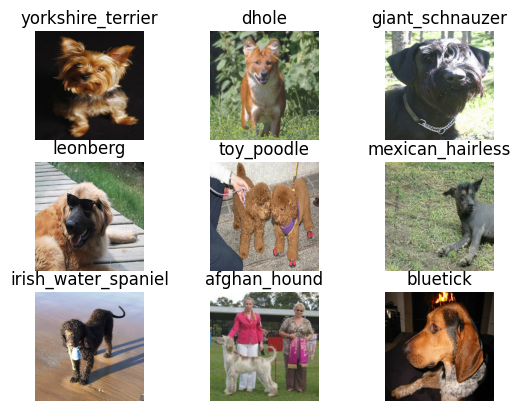

In [4]:
def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

#### Data augmentation

In [5]:
# Lớp tăng cường dữ liệu
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1),
]

#Hàm áp dụng tăng cường dữ liệu cho các ảnh
def img_augmentation(images):
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

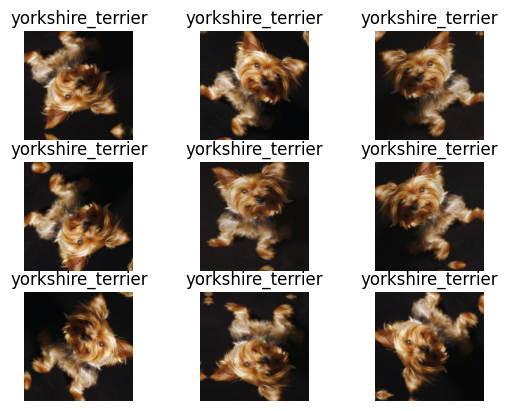

In [6]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(np.expand_dims(image.numpy(), axis=0))
        aug_img = np.array(aug_img)
        plt.imshow(aug_img[0].astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [7]:
# One-hot / categorical encoding
def input_preprocess_train(image, label):
    image = img_augmentation(image)
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


def input_preprocess_test(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

### Training a model from scratch

In [8]:
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 15  # @param {type: "slider", min:10, max:100}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 172s 569ms/step - accuracy: 0.0100 - loss: 5.0865 - val_accuracy: 0.0064 - val_loss: 4.8804
Epoch 2/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 102s 543ms/step - accuracy: 0.0198 - loss: 4.6292 - val_accuracy: 0.0161 - val_loss: 4.9402
Epoch 3/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 102s 543ms/step - accuracy: 0.0325 - loss: 4.4517 - val_accuracy: 0.0420 - val_loss: 4.4230
Epoch 4/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 142s 542ms/step - accuracy: 0.0419 - loss: 4.3171 - val_accuracy: 0.0304 - val_loss: 5.0991
Epoch 5/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 102s 544ms/step - accuracy: 0.0508 - loss: 4.2145 - val_accuracy: 0.0403 - val_loss: 4.8225
Epoch 6/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 102s 545ms/step - accuracy: 0.0587 - loss: 4.1271 - val_accuracy: 0.0525 - val_loss: 4.4168
Epoch 7/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 101s 542ms/step - accuracy: 0.0718 - loss: 4.0392 - val_accuracy: 0.0423 - val_loss: 7.4204
Epoch 8/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 101s 541ms/step - accuracy: 0.0775 -

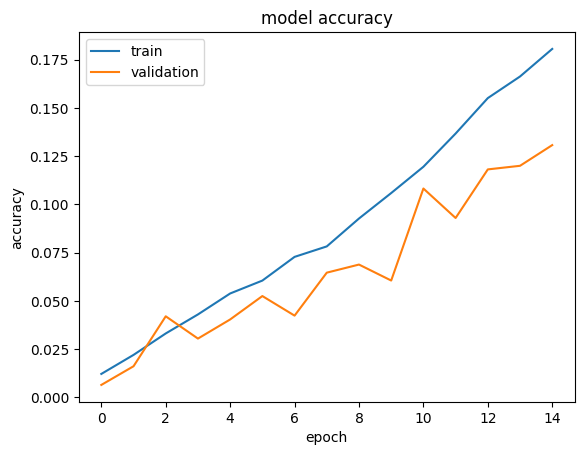

In [9]:
import matplotlib.pyplot as plt


def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()


plot_hist(hist)

**Nhận xét**
- Ban đầu, accuracy trên trainset và valset gần bằng nhau, đây là giai đoạn model được học các feature từ tập dữ liệu.
- Sau một thời gian, biểu đồ của accuracy cho thấy accuracy tăng nhanh và khá smooth. Cho thấy trong quá trình training model đang học khá tốt từ tập dữ liệu. Tuy nhiên, có khả năng model đang bị overfiting. Trong khi đó, tập valset lại cho thấy sự tăng chậm của accuracy và gấp khúc, điều đó cho thấy trong tập valset có nhiều dữ liệu mới, và model đang cố gắng tổng quát hóa nó.

### Transfer learning from pre-trained weights

In [13]:
def build_model(num_classes):
  #Định nghĩa đầu vào
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  #Tải các lớp Efficient B0 mà không bao gồm các lớp đầu ra cuối cùng, sử dụng tensor đầu vào đã định nghĩa, và các trọng sô đã được trained trước trên tâm imagenet
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Đóng băng các trọng số được huấn luyện trước đó.
    model.trainable = False

    # Xây dựng lại phần đầu ra
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 98s 434ms/step - accuracy: 0.2619 - loss: 4.3843 - val_accuracy: 0.6775 - val_loss: 1.1235
Epoch 2/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 75s 398ms/step - accuracy: 0.4910 - loss: 2.0585 - val_accuracy: 0.7340 - val_loss: 0.8764
Epoch 3/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 394ms/step - accuracy: 0.5394 - loss: 1.6848 - val_accuracy: 0.7512 - val_loss: 0.8244
Epoch 4/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 74s 395ms/step - accuracy: 0.5621 - loss: 1.5977 - val_accuracy: 0.7394 - val_loss: 0.8523
Epoch 5/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 75s 402ms/step - accuracy: 0.5649 - loss: 1.5429 - val_accuracy: 0.7442 - val_loss: 0.8776
Epoch 6/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 75s 400ms/step - accuracy: 0.5726 - loss: 1.5567 - val_accuracy: 0.7401 - val_loss: 0.8751
Epoch 7/15
187/187 ━━━━━━━━━━━━━━━━━━━━ 75s 400ms/step - accuracy: 0.5902 - loss: 1.4652 - val_accuracy: 0.7360 - val_loss: 0.8924
Epoch 8/15
187/187 ━━━━━━━━━━━━━

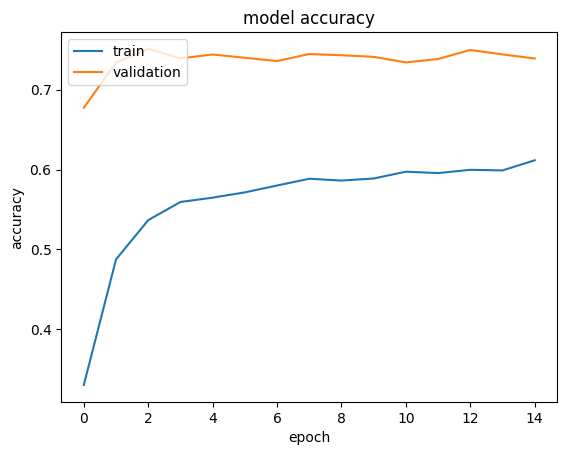

In [14]:
model = build_model(num_classes=NUM_CLASSES)

epochs = 15  # @param {type: "slider", min:8, max:80}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)

Epoch 1/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 100s 429ms/step - accuracy: 0.6153 - loss: 1.3522 - val_accuracy: 0.7522 - val_loss: 0.8735
Epoch 2/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 78s 415ms/step - accuracy: 0.6331 - loss: 1.2929 - val_accuracy: 0.7617 - val_loss: 0.8417
Epoch 3/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 82s 413ms/step - accuracy: 0.6506 - loss: 1.2387 - val_accuracy: 0.7688 - val_loss: 0.8209
Epoch 4/4
187/187 ━━━━━━━━━━━━━━━━━━━━ 77s 413ms/step - accuracy: 0.6580 - loss: 1.2080 - val_accuracy: 0.7705 - val_loss: 0.8043


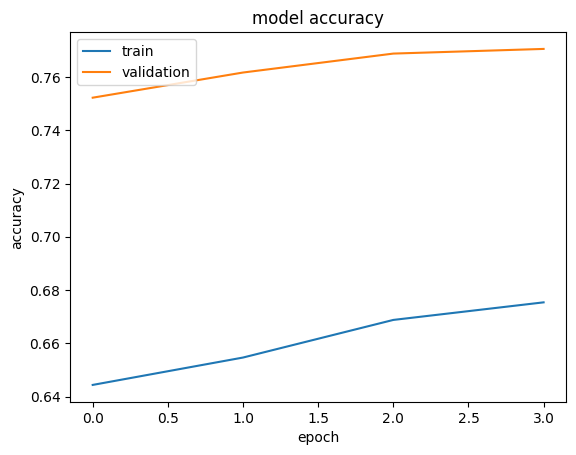

In [15]:
#Mở khóa các lớp của model để cho phép người dùng được trained, ngoại trừ các lớp BatchNormalization
def unfreeze_model(model):
    # Chúng tôi giải phóng 20 lớp trên cùng trong khi vẫn giữ nguyên các lớp BatchNorm
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):#Kiểm tra nếu lớp không phải là lớp BatchNormalization (if not isinstance(layer, layers.BatchNormalization)), thì đặt thuộc tính trainable của lớp đó thành True (layer.trainable = True).
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)

epochs = 4  # @param {type: "slider", min:4, max:10}
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test)
plot_hist(hist)